In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


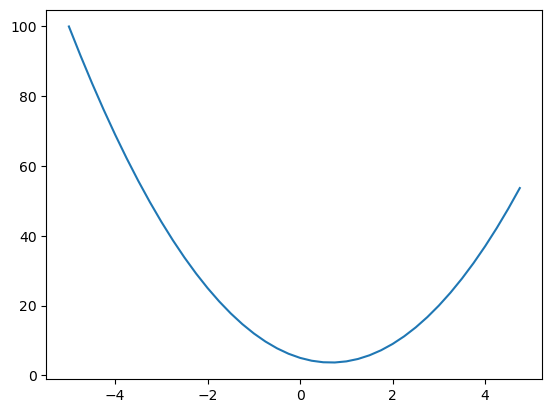

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(ys)
plt.plot(xs, ys)
plt.show()

In [4]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(f"d1 = {d1}")
print(f"d2 = {d2}")
print(f"slope = {(d2 - d1) / h}")

d1 = 4.0
d2 = 3.999699999999999
slope = -3.000000000010772


In [4]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # Used to define string repr of an object
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        # t = np.tanh(x)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    

    def backward(self):
        topo = []

        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [5]:
a = Value(8)
b = Value(4)

print(a*b)
print(a-b)
print(a/b)
print(a**5)

Value(data=32)
Value(data=4)
Value(data=2.0)
Value(data=32768)


In [ ]:
'''Divison Reorder
a/b
a * (1/b)
a * (b**-1)
'''

In [7]:
# print(d._prev)
# print(d._op)

In [1]:
!pip install graphviz

DEPRECATION: Loading egg at /Users/shivasaivummaji/miniconda3/envs/ptm_env/lib/python3.11/site-packages/huggingface_hub-0.29.2-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [8]:
!dot -V

dot - graphviz version 2.50.0 (0)


In [9]:
import graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR: left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create rectangular record
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this val is some operator
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

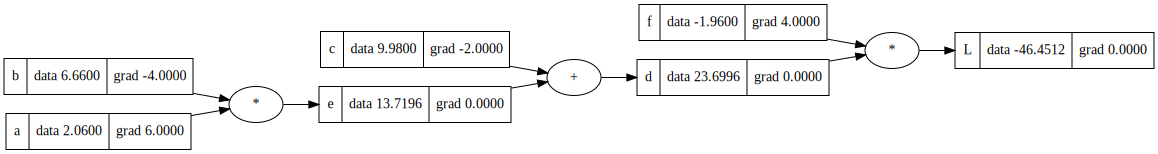

In [ ]:
# draw_dot(L)

In [ ]:
# # dL / dc 
# c.grad = -2
# e.grad = -2

In [ ]:
# a.grad = 6
# b.grad = -4

<!-- L = d * f

dL / dd = f

(f(x+h)-f(x))/h

((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f) / h
f -->

In [ ]:
# L.grad = 1.0
# f.grad = 4.0
# d.grad = -2

In [ ]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a*b; e.label = 'e'
# d = e+c; d.label = 'd'
# L = d*f; L.label = 'L'

# print(L.data)

-46.451216


In [ ]:
# def lol():
#     h = 0.0001

#     a = Value(2.0, label='a')        
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     e = a*b; e.label='e'
#     d = e + c; d.label='d'
#     f = Value(-2.0, label='f')
#     L = d * f
#     L.label = 'L'
#     L1 = L.data

#     a = Value(2.0, label='a')        
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     e = a*b; e.label='e'
#     d = e + c; d.label='d'
#     f = Value(-2.0, label='f')
#     L = d * f
#     L.label = 'L'
#     L2 = L.data 

#     print((L2 - L1) / h)


# lol()

0.0


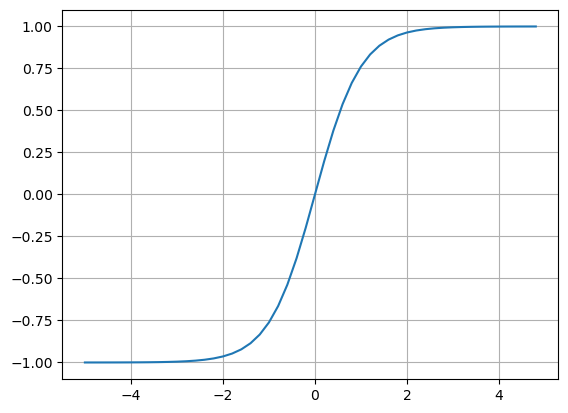

In [89]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [13]:
# inputs x1, x2

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights = w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias of the neuron
b = Value(6.88137, label="b")

# sum(w_i*x_i) + b = x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = "x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"

o = n.tanh() # hyperbolic 
o.label = "o"
o.backward()

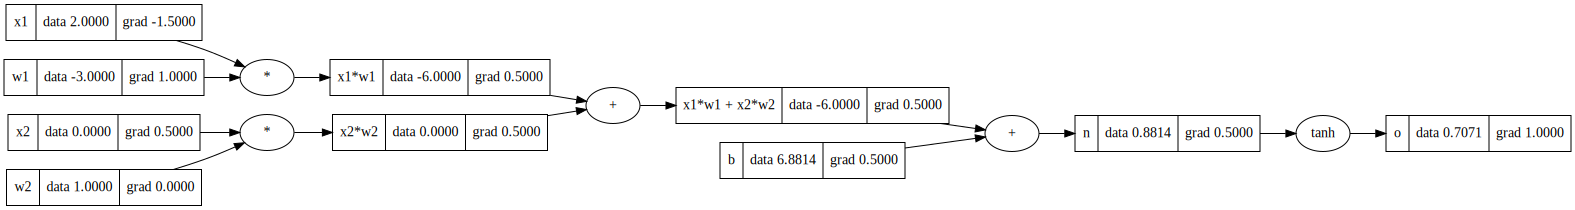

In [14]:
draw_dot(o)

In [100]:
o.backward()

In [ ]:
# o.grad = 1.0 # Base case
# o._backward()

In [ ]:
# n._backward()

In [ ]:
# b._backward() # nothing happens
# x1w1x2w2._backward()

In [ ]:
# x2w2._backward()
# x1w1._backward()

In [ ]:
# # Manual back-prop

# o.grad = 1.0
# n.grad = 1 - o.data**2 # 0.5

# b.grad = 0.5 # additive node
# x1w1x2w2.grad = 0.5 # additive node

# x1w1.grad = 0.5 # additive node
# x2w2.grad = 0.5 # additive node

# w2.grad = x2.data * x2w2.grad
# x2.grad = w2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2 --> do/dn = 1 - o^2

In [ ]:
# x1.data * x1w1.grad

1.0

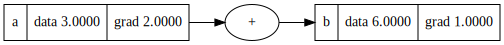

In [102]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

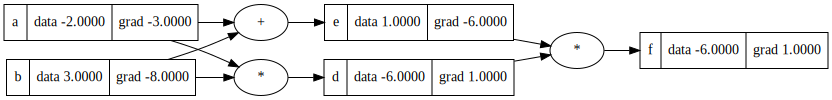

In [103]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label = "d"
e = a + b; e.label="e"
f = d*e; f.label="f"

f.backward()
draw_dot(f)

In [15]:
# inputs x1, x2

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights = w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias of the neuron
b = Value(6.88137, label="b")

# sum(w_i*x_i) + b = x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = "x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"
# --

e = (2*n).exp()
o = (e-1) / (e+1)
# --
o.label = "o"
o.backward()

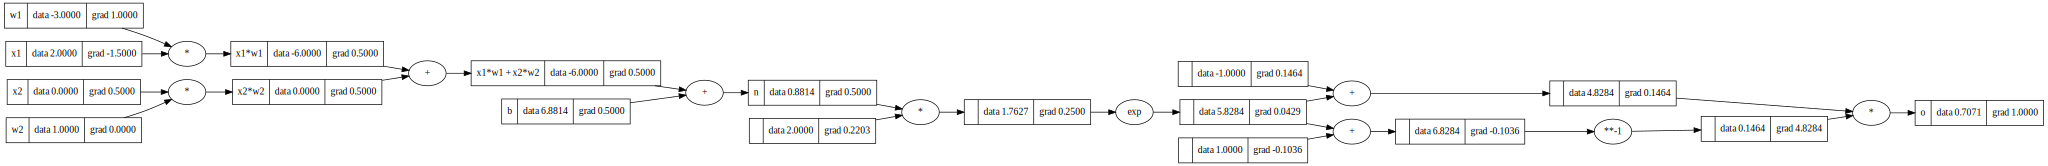

In [16]:
draw_dot(o)

In [10]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8814]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071200415967962
---
x2 0.4999812467721452
w2 0.0
x1 -1.4999437403164357
w1 0.9999624935442905


In [12]:
import random

In [72]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [73]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.30119874877270586)

In [24]:
len(n.parameters())

41

In [25]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.6698098646463161),
 Value(data=-0.38779410763581185),
 Value(data=-0.05623676526806038),
 Value(data=0.7875959678981436)]

In [26]:
ys = [1.0, -1.0, -1.0, 1.0]
ys = [Value(i) for i in ys]
print(ys)

[Value(data=1.0), Value(data=-1.0), Value(data=-1.0), Value(data=1.0)]


In [27]:
loss = Value(0.0)
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2

print(loss)

Value(data=1.4196260962151366)


In [53]:
ypred = [n(x) for x in xs]
loss = Value(0.0)
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2

print(loss)

Value(data=0.00019527416394465467)


In [47]:
loss.backward()

In [48]:
n.layers[0].neurons[0].w[0].grad

-1.406883190974714

In [49]:
n.layers[0].neurons[0].w[0].data

-0.35108179234818787

In [ ]:
for p in n.parameters():
    p.data += -0.01 * p.grad


In [51]:
n.layers[0].neurons[0].w[0].data

-0.21039347325071647

In [54]:
ypred

[Value(data=0.990653858427516),
 Value(data=-0.9994827460334456),
 Value(data=-0.9989500586520643),
 Value(data=0.9896775064470004)]

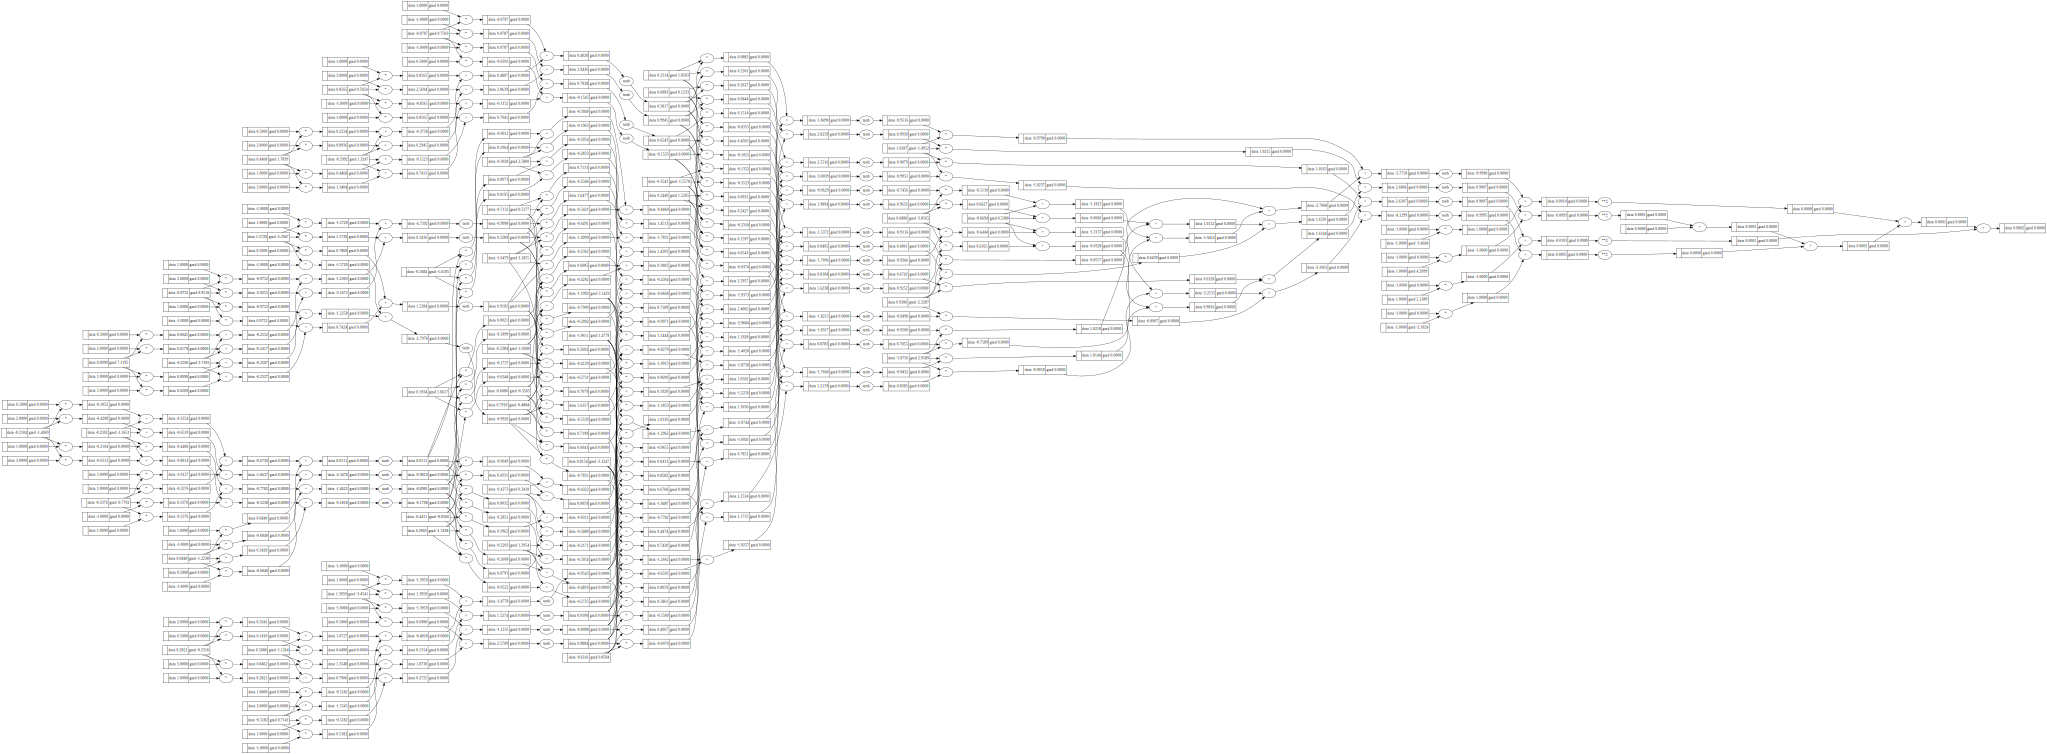

In [55]:
draw_dot(loss)

In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

In [83]:
for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = Value(0.0)
    for ygt, yout in zip(ys, ypred):
        loss += (yout - ygt)**2

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 0.06333154790189682
1 0.06210501091765984
2 0.0609205375162353
3 0.059776119280134606
4 0.05866986866208955
5 0.05760001030801311
6 0.056564873097266925
7 0.05556288283361469
8 0.05459255552706259
9 0.053652491212857645


In [84]:
ypred

[Value(data=0.8763707318924145),
 Value(data=-0.9542790999693402),
 Value(data=-0.8502991751669563),
 Value(data=0.8822394054671377)]